In [3]:
import sys

sys.path.append("/vol/biomedic3/mb121/causal-contrastive")
from torchvision.transforms import (
    Resize,
    CenterCrop,
    ToTensor,
    RandomAffine,
    ColorJitter,
    RandomResizedCrop,
)
from skimage import io
import matplotlib.pyplot as plt
from data_handling.mammo import preprocess_breast, get_embed_csv, modelname_map
from pathlib import Path
import matplotlib
import matplotlib.patches as patches

matplotlib.rcParams["font.family"] = "serif"
import seaborn as sns
from data_handling.padchest import prepare_padchest_csv

# Some random images for figure 1

In [ ]:
path = "/vol/biomedic3/data/EMBED/images/png/1024x768/10000879/1.2.826.0.1.3680043.8.498.10392068038916878965464813474172245832.png"
path_cf = "/vol/biomedic3/mb121/causal-contrastive/cf_beta1balanced_scanner/10000879/1.2.826.0.1.3680043.8.498.10392068038916878965464813474172245832_s3.png"
img1 = CenterCrop((224, 192))(preprocess_breast(str(path_cf), (256, 192))[0])
plt.imshow(img1[0], cmap="gray")
plt.axis("off");

In [ ]:
path_cf = "/vol/biomedic3/mb121/causal-contrastive/cf_beta1balanced_scanner/10000879/1.2.826.0.1.3680043.8.498.10392068038916878965464813474172245832_s3.png"
img1 = CenterCrop((224, 192))(preprocess_breast(str(path_cf), (256, 192))[0])
plt.imshow(img1[0], cmap="gray")
plt.axis("off")

In [ ]:
path = "/vol/biomedic3/data/EMBED/images/png/1024x768/10000879/1.2.826.0.1.3680043.8.498.10392068038916878965464813474172245832.png"
img1 = ColorJitter(contrast=0.5, brightness=0.5)(
    CenterCrop((224, 192))(
        RandomAffine(30)((preprocess_breast(str(path), (256, 192))[0]))
    )
)
plt.imshow(img1[0], cmap="gray", vmin=0, vmax=1)
plt.axis("off")

# Visualisation of counterfactuals

In [15]:
rev_model_map

{0: 'Selenia Dimensions',
 5: 'Senographe Essential VERSION ADS_54.10',
 2: 'Senograph 2000D ADS_17.5',
 3: 'Lorad Selenia',
 4: 'Clearview CSm',
 1: 'Senographe Pristina'}

SimpleModelLabel
0    374169
2     13268
3     10515
4      8128
1       498
Name: count, dtype: int64


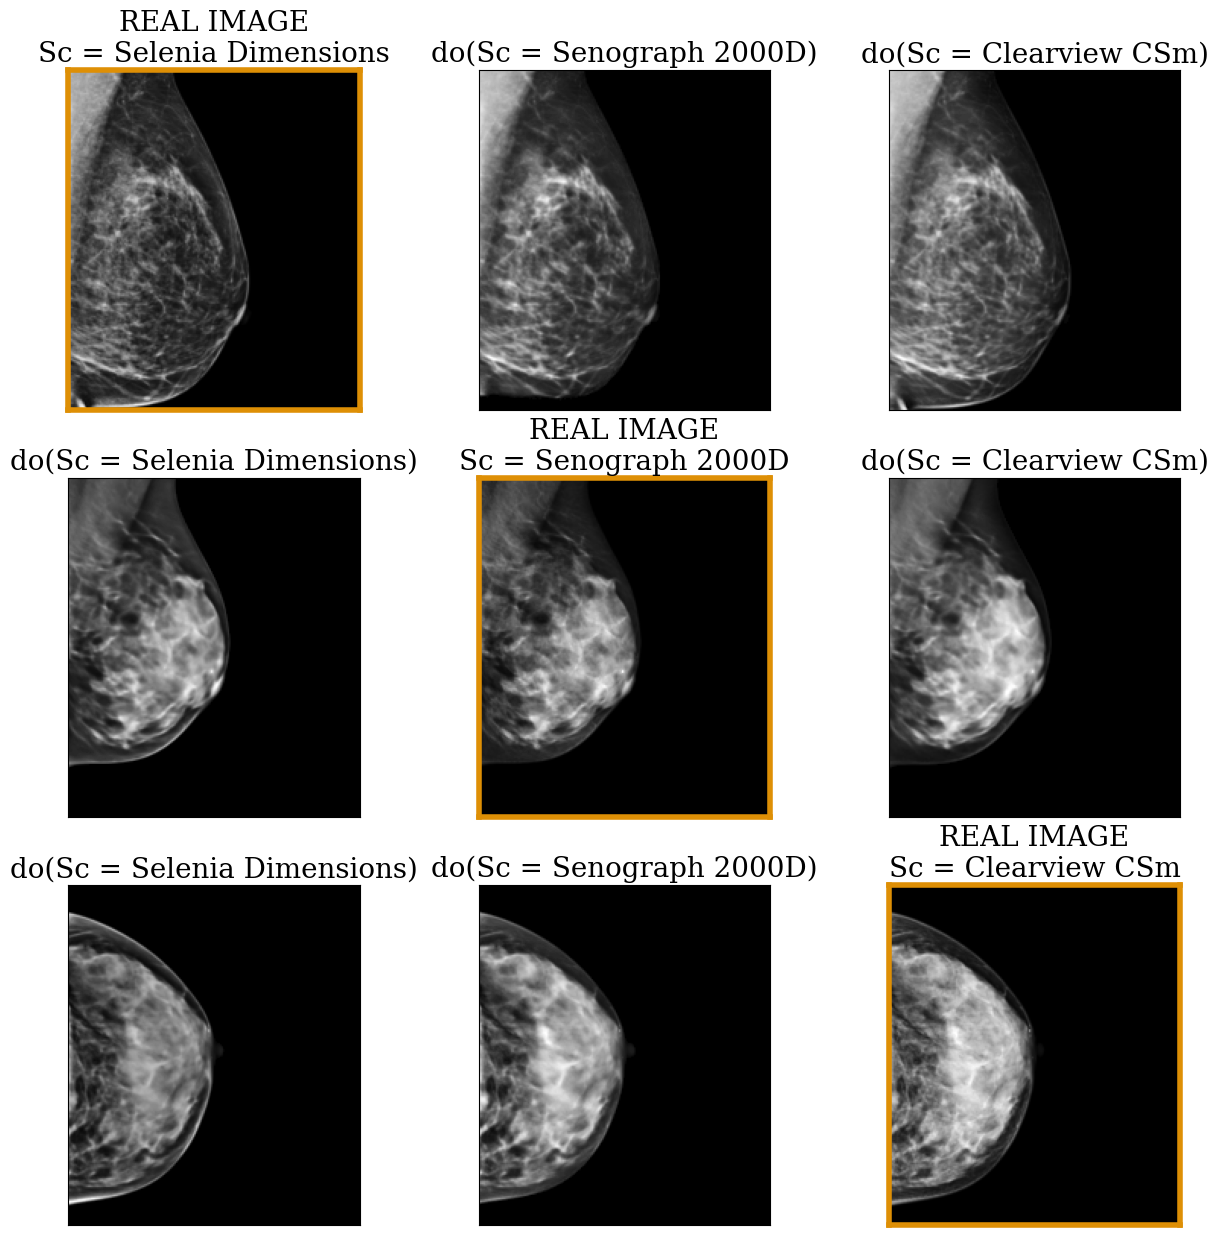

In [18]:
df = get_embed_csv()

rev_model_map = {v: k for k, v in modelname_map.items()}
rev_model_map[2] = "Senograph 2000D"
f, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, s in enumerate([0, 2, 4]):
    shortpath = df.loc[df.SimpleModelLabel == s, "shortimgpath"].values[1]
    path = Path("/vol/biomedic3/data/EMBED/images/png/1024x768") / shortpath

    for j, cf in enumerate([0, 2, 4]):
        path_cf = (
            Path("/vol/biomedic3/mb121/causal-contrastive/cf_beta1balanced_scanner")
            / f"{shortpath[:-4]}_s{cf}.png"
        )
        if Path(path_cf).exists():
            img1 = CenterCrop((224, 192))(
                preprocess_breast(str(path_cf), (256, 192))[0]
            )
            ax[i, j].set_title(f"do(Sc = {rev_model_map[cf]})", fontsize=20)
        else:
            img1 = CenterCrop((224, 192))(preprocess_breast(str(path), (256, 192))[0])
            ax[i, j].set_title(f"REAL IMAGE\nSc = {rev_model_map[cf]}", fontsize=20)
            # Choose the subplot to highlight with a red frame (in this case, the bottom-right subplot)
            highlighted_subplot = ax[i, j]
            linewidth = 4  # Set the desired linewidth
            for spine in highlighted_subplot.spines.values():
                spine.set_color(sns.color_palette("colorblind", 3)[1])
                spine.set_linewidth(linewidth)

        ax[i, j].imshow(img1[0], cmap="gray")
        ax[i, j].set_xticks([]), ax[i, j].set_yticks([])

plt.savefig("cf_viz.pdf", bbox_inches="tight")

normal
False    57332
True     34343
Name: count, dtype: int64
pleural effusion
False    88416
True      3259
Name: count, dtype: int64
pneumonia
False    88389
True      3286
Name: count, dtype: int64
exclude
False    90862
True       813
Name: count, dtype: int64
suboptimal study
False    91024
True       651
Name: count, dtype: int64
cardiomegaly
False    83255
True      8420
Name: count, dtype: int64


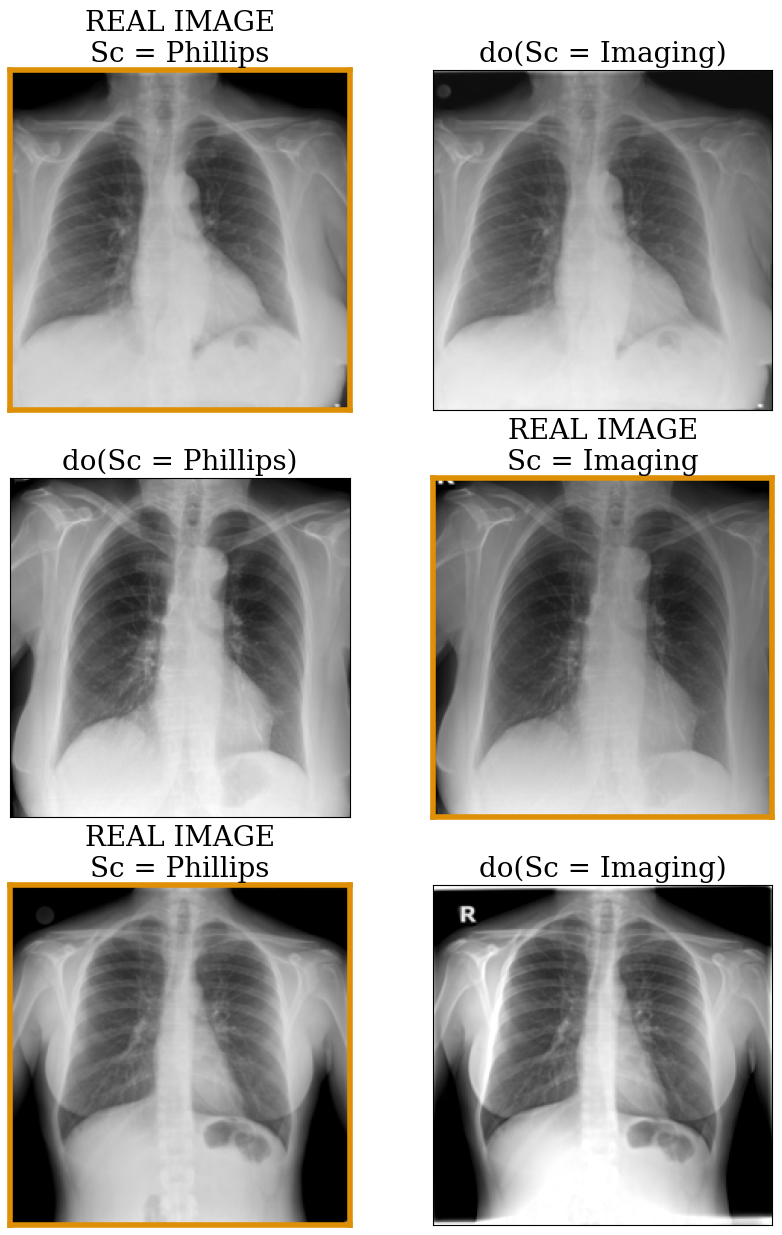

In [20]:
from sklearn.model_selection import train_test_split

df = prepare_padchest_csv()
train_val_id, _ = train_test_split(
    df.PatientID.unique(),
    test_size=0.20,
    random_state=33,
)

train_id, _ = train_test_split(
    train_val_id,
    test_size=0.10,
    random_state=33,
)
df = df.loc[df.PatientID.isin(train_id)]
f, ax = plt.subplots(3, 2, figsize=(10, 15))

for i, s in enumerate(["Phillips", "Imaging", "Phillips"]):
    shortpath = df.loc[df.Manufacturer == s, "ImageID"].values[i + 1]
    path = Path("/vol/biodata/data/chest_xray/BIMCV-PADCHEST") / "images" / shortpath

    for j, cf in enumerate(["Phillips", "Imaging"]):
        if cf != s:
            path_cf = Path("../padchest_cf_images_v0") / f"{shortpath[:-4]}_sc_cf.png"
            img = io.imread(str(path_cf), as_gray=True)
            ax[i, j].set_title(f"do(Sc = {cf})", fontsize=20)
        else:
            img = io.imread(str(path), as_gray=True)
            ax[i, j].set_title(f"REAL IMAGE\nSc = {cf}", fontsize=20)
            # Choose the subplot to highlight with a red frame (in this case, the bottom-right subplot)
            highlighted_subplot = ax[i, j]
            linewidth = 4  # Set the desired linewidth
            for spine in highlighted_subplot.spines.values():
                spine.set_color(sns.color_palette("colorblind", 3)[1])
                spine.set_linewidth(linewidth)
        img = img / (img.max() + 1e-12)
        img = CenterCrop(224)(Resize(224, antialias=True)(ToTensor()(img)))[0]
        ax[i, j].imshow(img, cmap="gray", vmin=0, vmax=1)
        ax[i, j].set_xticks([]), ax[i, j].set_yticks([])

plt.savefig("cf_viz_cxr.pdf", bbox_inches="tight")

In [3]:
import pandas as pd
from pathlib import Path

PADCHEST_ROOT = Path("/vol/biodata/data/chest_xray/BIMCV-PADCHEST")
PADCHEST_IMAGES = PADCHEST_ROOT / "images"


df = pd.read_csv(PADCHEST_ROOT / "PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv")
len(df)

160861